In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import datetime
from unidecode import unidecode
import unicodedata
import re
import copy
import pickle
from scipy.stats import norm, multivariate_normal, weibull_min, chi2


We first download the necessary data from previous notebooks, namely the expected goals model and the associated parameters.

In [2]:
EPL_games = pd.read_csv("/Users/kmason/Desktop/Folders/sports_gambling_exploration/soccer/data/EPL_games_events/matches.csv")

/var/folders/tf/8hslpl416b70psyc3zvyzfxm0000gn/T/ipykernel_55764/2751426168.py:1: DtypeWarning: Columns (136,141,143,145,146,148,149,151,152,154) have mixed types. Specify dtype option on import or set low_memory=False.
  EPL_games = pd.read_csv("/Users/kmason/Desktop/Folders/sports_gambling_exploration/soccer/data/EPL_games_events/matches.csv")


In [3]:
import pickle

# Load game events
with open('data/game_events.pkl', 'rb') as f:
    game_events = pickle.load(f)

# Load mappings of names to player ids
with open('data/all_name_to_id.pkl', 'rb') as f:
    all_name_to_id = pickle.load(f)

with open('data/first_name_to_id.pkl', 'rb') as f:
    first_name_to_id = pickle.load(f)

with open('data/last_name_to_id.pkl', 'rb') as f:
    last_name_to_id = pickle.load(f)

# Load player ratings dictionary (key = player id)
with open('data/player_ratings.pkl', 'rb') as f:
    player_ratings = pickle.load(f)

# Load regular table of players (just in case)
with open('data/all_fifa_player_ratings.pkl', 'rb') as f:
    all_fifa_ratings = pickle.load(f)

# Load game events
with open('data/xg_rate_parameters.pkl', 'rb') as f:
    xg_rate_parameters = pickle.load(f)



# Load game events
with open('data/xg_data_matrix.pkl', 'rb') as f:
    data_with_dummies = pickle.load(f)

# Load general data matrix 
with open('data/general_data_matrix.pkl', 'rb') as f:
    data = pickle.load(f)



# Load xg model
with open('data/xg_model.pkl', 'rb') as f:
    xg_model = pickle.load(f)



## Joint Distribution of Goal Scoring Timings Between Teams
From the previous notebook, we know that a Weibull distribution is a good fit for modeling the time until a goal for a team marginally. However, since teams are competing, we cannot model their timings independently. To model the joint distribution between teams, we use a Gaussian copula. Specifically, by letting the correlation between teams in the copula be 
$\rho$, we fit $\rho$ under different game states. The game states considered are all combinations of half, extra time, and score differential (tied vs. not). Our data for a time period of length $t$ is either that one team scores at time $t$ and one team does not or that both teams don't score by time $t$. Scoring at time $t$ can be transformed to a number between 0 and 1 by applying the probability integral transform to the marginal distribution of each team's goal scoring timings. Call the home and away team's rates $F_H$ and $F_A$ respectively and the transformed values $U_H$ and $U_A$ respectively. Assuming a form of the copula, we can easily compute probabilities of the form $P(U_H > F_H^{-1}(t),U_A > F_A^{-1}(t))$, $(U_H > F_H^{-1}(t),U_A = F_A^{-1}(t))$ , and $(U_H = F_H^{-1}(t),U_A > F_A^{-1}(t))$ which are exactly the likelihoods of the data we observe.

In [4]:
#read in hazard data
hazard_data = data.copy()
#add predicted xg 
hazard_data['predicted_xg'] = data_with_dummies['predicted_xg']
hazard_data['predicted_xg_rate'] = data_with_dummies['predicted_xg']/data_with_dummies['period_length']
hazard_data['xg'] = hazard_data['xg_rate']*hazard_data['period_length']

In [5]:
#get rho from copula
#(X_1,X_2) \sim (Expo(1),expo(2)) marginally
#need function to compute cdf of exponential (marginal uniform)
def weibull_cdf(rate,x):
    return weibull_min.cdf(x,c = 1.1, loc = 0, scale = 1/rate)
#need function to convert uniform to normal
def normal_component(x):
    return norm.ppf(x)
def normal_terminal_no_goal(time_elapse,rate_1,rate_2,rho):
    mean = [0, 0]  # Mean of the bivariate normal distribution
    cov = [[1, rho], [rho, 1]]  # Covariance matrix
    # Create a multivariate normal distribution object
    rv = multivariate_normal(mean, cov)

    #first get unfirom
    U1 = weibull_cdf(rate = rate_1, x = time_elapse)
    U2 =  weibull_cdf(rate = rate_2, x = time_elapse)
    #get normal components
    Z1 = normal_component(U1)
    Z2 = normal_component(U2)
    #get complementary CDF P(X>x,Y > y) = 1- P(X<x) - P(Y<y) + P(X < x, Y < y)
    C = 1 - norm.cdf(Z1) - norm.cdf(Z2) + rv.cdf([Z1, Z2])
    return C

#conditional distribution of bivaraite normal
#(X,Y) ~ MVN(0,rho)
#X = Z
#Y = rho*Z + \sqrt(1-rho^2)W
#Y|X = x ~  N(rho*x,1-rho^2)

def normal_team_goal(time_elapse,rate_1,rate_2,rho,team):
    #first get unfirom
    U1 = weibull_cdf(rate = rate_1, x = time_elapse)
    U2 =  weibull_cdf(rate = rate_2, x = time_elapse)
    #get normal components
    Z1 = normal_component(U1)
    Z2 = normal_component(U2)
    #get complementary CDF P(X>x,Y > y) = 1- P(X<x) - P(Y<y) + P(X < x, Y < y)
    if team == 1:
        A = norm.pdf(Z1)
        B = 1 - norm.cdf(Z2, loc=rho*Z1, scale= np.sqrt(1- rho**2))
    if team == 2:
        A = norm.pdf(Z2)
        B = 1 - norm.cdf(Z1, loc=rho*Z2, scale=np.sqrt(1- rho**2))
    return A*B
#need function to get ccdf of bivarite normal 

In [6]:
# Define categories without distinguishing between "close" and "mismatch"
categories = [
    ("tied", 1, 0),
    ("tied", 1, 1),
    ("tied", 2, 0),
    ("tied", 2, 1),
    ("up_down", 1, 0),  # Combined up_down_1, up_down_2_plus
    ("up_down", 1, 1),  # Combined up_down_1, up_down_2_plus
    ("up_down", 2, 0),  # Combined up_down_1, up_down_2_plus
    ("up_down", 2, 1),  # Combined up_down_1, up_down_2_plus
]

# Initialize the results dictionary
correlation_by_game_state = {category: None for category in categories}

# Iterate over each category to calculate the Min value
for score_diff_category, half, extra_time in categories:
    counter = 0
    n = int(hazard_data.shape[0] / 2)
    #minimum correlation
    Min = -0.90
    #maximum correlation
    Max = 0.90
    #how close to the true optimal value we want our binary search to find 
    acc = 0.01
    #step size for derivative calc
    h = 1e-3

    while Max - Min > acc:
        rho = 0.5 * (Min + Max)
        rho_epsilon = rho + h
        liks = 0
        liks_epsilon = 0

        for j in range(n):
            # Check the score differential to match the current category
            if score_diff_category == "tied" and hazard_data.iloc[2 * j]['score_differential'] != "tied":
                continue
            if score_diff_category == "up_down" and hazard_data.iloc[2 * j]['score_differential'] not in ["up_1", "down_1", "up_2", "down_2", "up_2_plus", "down_2_plus"]:
                continue

            # Check for the correct half and extra time
            if hazard_data.iloc[2 * j]['half'] != half or hazard_data.iloc[2 * j]['extra_time'] != extra_time:
                continue

            # Get rows for this event
            data_team_1 = hazard_data.iloc[2 * j]
            data_team_2 = hazard_data.iloc[2 * j + 1]

            # Get team rates
            team_1_rate = data_team_1['predicted_xg_rate']
            team_2_rate = data_team_2['predicted_xg_rate']
            if team_1_rate < 0 or team_2_rate < 0:
                continue

            # Get length of period
            time_elapse = data_team_1['period_length']
            if time_elapse == 0:
                continue

            # Check event and calculate likelihood
            event = data_team_1['pause']
            if event in [("Goal", data_team_1['team']), ("Own Goal", data_team_2['team'])]:
                liks += np.log(normal_team_goal(time_elapse, team_1_rate, team_2_rate, rho, team=1))
                liks_epsilon += np.log(normal_team_goal(time_elapse, team_1_rate, team_2_rate, rho_epsilon, team=1))
            elif event in [("Goal", data_team_2['team']), ("Own Goal", data_team_1['team'])]:
                liks += np.log(normal_team_goal(time_elapse, team_1_rate, team_2_rate, rho, team=2))
                liks_epsilon += np.log(normal_team_goal(time_elapse, team_1_rate, team_2_rate, rho_epsilon, team=2))
            else:
                liks += np.log(normal_terminal_no_goal(time_elapse, team_1_rate, team_2_rate, rho))
                liks_epsilon += np.log(normal_terminal_no_goal(time_elapse, team_1_rate, team_2_rate, rho_epsilon))

        if liks_epsilon > liks:
            Min = rho
        else:
            Max = rho

    # Store the Min value for this category
    correlation_by_game_state[(score_diff_category, half, extra_time)] = tuple((Min, counter))


## Results
We observe that the correlation between teams is consistently negative across all game states. This aligns with the expectation that teams are competing for possession of the ball. Additionally, we notice an increase in the absolute value of the correlation in the second half, during extra time, and when a team is trailing by a goal. This is consistent with the idea that teams tend to increase their aggression in these situations. It also supports the theory that, although our xG model found that a team's goal-scoring rate may decrease when they are behind—possibly due to forcing attempts—the increased aggression serves to raise the variance in the score.

In [7]:
print(correlation_by_game_state)

{('tied', 1, 0): (-0.27421875, 0), ('tied', 1, 1): (-0.42890625, 0), ('tied', 2, 0): (-0.48515625, 0), ('tied', 2, 1): (-0.7734375000000001, 0), ('up_down', 1, 0): (-0.39375000000000004, 0), ('up_down', 1, 1): (-0.7945312500000001, 0), ('up_down', 2, 0): (-0.62578125, 0), ('up_down', 2, 1): (-0.8578125, 0)}


# Simulating Games
Now that we have an xg model as well as a way to sample from the joint distribution of goal scoring timings between teams, we can simulate an entire game. 

In [8]:
# Function to simulate a goal
def simulate_goal(r1, r2, rho, time_remaining, seed=None):
    # Set the seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Simulate from a bivariate Gaussian with correlation rho
    mean = [0, 0]  # Mean of the bivariate normal distribution
    cov = [[1, rho], [rho, 1]]  # Covariance matrix
    # Create a multivariate normal distribution object
    rv = multivariate_normal(mean, cov)
    # Get values
    BVN = rv.rvs(size=1)
    # Turn into uniforms
    U1 = norm.cdf(BVN[0])
    U2 = norm.cdf(BVN[1])
    # Turn into Weibulls
    W1 = weibull_min.ppf(U1, 1.1146, loc=0, scale=1/r1)
    W2 = weibull_min.ppf(U2, 1.1146, loc=0, scale=1/r2)

    # Get minimum and see if it occurs before time ends
    if W1 < W2 and W1 < time_remaining:
        return [W1, 1]
    elif W2 < W1 and W2 < time_remaining:
        return [W2, 2]
    else:
        return [time_remaining, 0]

# Function to simulate a game
def simulate_game(r1, r2, half, extra_time, scores_initial, rhos, parameter_means, time_start, seed=None):
    scores = scores_initial.copy()
    score_differential = scores[0] - scores[1]
    if score_differential != 0:
        S = "up_down"
    else:
        S = "tied"
    if score_differential == 0:
        score_effect_1 = parameter_means['score_differential_tied']
        score_effect_2 = parameter_means['score_differential_tied']
    elif score_differential == 1:
        score_effect_1 = parameter_means['score_differential_up_1']
        score_effect_2 = 0
    elif score_differential == -1:
        score_effect_1 = 0
        score_effect_2 = parameter_means['score_differential_up_1']
    elif score_differential == 2:
        score_effect_1 = parameter_means['score_differential_up_2']
        score_effect_2 = parameter_means['score_differential_down_2']
    elif score_differential == -2:
        score_effect_1 = parameter_means['score_differential_down_2']
        score_effect_2 = parameter_means['score_differential_up_2']
    elif score_differential >= 3:
        score_effect_1 = parameter_means['score_differential_up_3_plus']
        score_effect_2 = parameter_means['score_differential_down_3_plus']
    elif score_differential <= -3:
        score_effect_1 = parameter_means['score_differential_down_3_plus']
        score_effect_2 = parameter_means['score_differential_up_3_plus']
    
    # Get rho 
    rho = rhos[tuple((S, half, extra_time))][0]

    # Set the seed if provided
    if seed is not None:
        np.random.seed(seed)
    else:
        seed = np.random.randint(1e8)

    if half == 1 and time_start < 45:
        time_remaining = 45 - time_start
        # Simulate next goal 
        next_goal = simulate_goal(r1 + score_effect_1, r2 + score_effect_2, rho, time_remaining, seed + 1)
        # Update goals and check if half ended 
        if next_goal[1] == 1:
            scores[0] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 2:
            scores[1] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 0:
            r1 = r1 + parameter_means['extra_time_1']
            r2 = r2 + parameter_means['extra_time_1']
            extra_time = 1
            time_start = 45
        seed = np.random.randint(1,1e8)
        return simulate_game(r1, r2, half, extra_time, scores, rhos, parameter_means, time_start, seed)

    elif half == 1 and extra_time == 1:
        time_remaining = 50 - time_start
        next_goal = simulate_goal(r1 + score_effect_1, r2 + score_effect_2, rho, time_remaining, seed)
        # Update goals and check if half ended 
        if next_goal[1] == 1:
            scores[0] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 2:
            scores[1] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 0:
            r1 = r1 + parameter_means['half_2']
            r2 = r2 + parameter_means['half_2']
            r1 = r1 - parameter_means['extra_time_1']
            r2 = r2 - parameter_means['extra_time_1']
            extra_time = 0
            half = 2
            time_start = 50
        seed = np.random.randint(1,1e8)
        return simulate_game(r1, r2, half, extra_time, scores, rhos, parameter_means, time_start, seed)

    elif half == 2 and time_start < 95:
        time_remaining = 95 - time_start
        next_goal = simulate_goal(r1 + score_effect_1, r2 + score_effect_2, rho, time_remaining, seed)
        # Update goals and check if half ended 
        if next_goal[1] == 1:
            scores[0] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 2:
            scores[1] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 0:
            r1 = r1 + parameter_means['extra_time_1']
            r2 = r2 + parameter_means['extra_time_1']
            extra_time = 1
            time_start = 95
        seed = np.random.randint(1,1e8)
        return simulate_game(r1, r2, half, extra_time, scores, rhos, parameter_means, time_start, seed )

    elif half == 2 and extra_time == 1:
        time_remaining = 100 - time_start
        next_goal = simulate_goal(r1 + score_effect_1, r2 + score_effect_2, rho, time_remaining, seed)
        # Update goals and check if half ended 
        if next_goal[1] == 1:
            scores[0] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 2:
            scores[1] += 1
            time_start += next_goal[0]
        elif next_goal[1] == 0:
            extra_time = 0
            time_start = 100
        seed = np.random.randint(1,1e8)
        return simulate_game(r1, r2, half, extra_time, scores, rhos, parameter_means, time_start, seed)
    
    # If the game ends, return the score
    if half == 2 and time_start == 100:
        return scores

# Function to simulate multiple games
def simulate_games(r1, r2, half, extra_time, scores_initial, rhos, parameter_means, time_start, nsim, seed=None):
    results = [0, 0, 0]
    if seed is None:
        seed = np.random.randint(1,1e8)
    for j in range(nsim):
        # Get game result
        game_result = simulate_game(r1, r2, half, extra_time, scores_initial, rhos, parameter_means, time_start, seed+j)
        # Append result to list
        if game_result[0] > game_result[1]:
            results[0] += 1
        elif game_result[1] > game_result[0]:
            results[1] += 1
        else:
            results[2] += 1
    return [v / nsim for v in results]


In [9]:
#get parameter means and rhos by game state dictionary 
parameter_means = {}
for key in xg_rate_parameters:
    parameter_means[key] = np.mean(xg_rate_parameters[key])

rhos = correlation_by_game_state

## Comparing Simulations to True Games
We now compare our simulations to the results of the actual games in our dataset. Our input is the starting goal rate for each team. Note that the simulations do not include substitutions, but since the effects of substitutions are relatively small overall, if the simulations are accurate, the expected results should closely approximate the observed results.

In [10]:
initial_parameters = {}
true_results =  {}
for j in range(hazard_data.shape[0]):
    id = hazard_data.iloc[j]['id']
    game_results = EPL_games[EPL_games['id'] == id]
    if id not in initial_parameters:
        #get team names 
        home_team = hazard_data.iloc[j]['team']
        away_team = hazard_data.iloc[j+1]['team']
        #get initial rates
        home_rate = hazard_data.iloc[j]['predicted_xg_rate']
        away_rate = hazard_data.iloc[j + 1]['predicted_xg_rate']
        #add to dict
        initial_parameters[id] = [tuple((home_team,home_rate)), tuple((away_team,away_rate))]
        true_results[id] = [tuple((game_results.iloc[0]['home'],game_results.iloc[0]['home_score'])),tuple((game_results.iloc[0]['away'],game_results.iloc[0]['away_score']))]



### Simualting over a range of starting rates
We simulate over a grid of goal-scoring rates and then project the games in our sample to the nearest simulated example. Note that there is some noise in our simulated estimates of win probabilities, but with 2,000 simulations, this should be a relatively small effect.

In [11]:
R1 = np.linspace(0.01,0.02,20)
R2 = np.linspace(0.005,0.0175,20)
predicted_winrate = {}
nsim = 2000
for r1 in R1:
    for r2 in R2:
        #simulate game 
        predicted_winrate[tuple((r1,r2))] = simulate_games(r1 = r1, r2 = r2, half = 1, extra_time = 0, scores_initial = [0,0],
                                                           rhos = correlation_by_game_state,parameter_means= parameter_means,time_start = 0, nsim = nsim,seed = 1)

In [12]:
#view expected wins and what not vs actual 
expected_prop = np.array([0,0,0])
observed_prop = np.array([0,0,0])

expected_results = {}
observed_results = {}
for key in initial_parameters:
    r1 = initial_parameters[key][0][1]
    r2 = initial_parameters[key][1][1]

    #if r1 < 0.01 or r1 > 0.02 or r2 < 0.005 or r2 > 0.0175:
        #continue
    # Find the closest value in R1 to a
    closest_a = R1[np.argmin(np.abs(R1 - r1))]

    # Find the closest value in R2 to b
    closest_b = R2[np.argmin(np.abs(R2 - r2))]

    # The resulting tuple with the closest values
    closest_tuple = (closest_a, closest_b)

    #get predicted win rate
    win_prob = np.array(predicted_winrate[closest_tuple])
    expected_results[key] = win_prob
    expected_prop = expected_prop + win_prob
    #get true score
    observed_game = true_results[key]
    home_score = observed_game[0][1]
    away_score = observed_game[1][1]
    if home_score > away_score:
        observed_prop[0] += 1
        observed_results[key] = np.array([1,0,0])
    elif away_score > home_score:
        observed_prop[1] += 1
        observed_results[key] = np.array([0,1,0])
    else:
        observed_prop[2] += 1
        observed_results[key] = np.array([0,0,1])



### Overall Win-Loss-Tie Proportions
We see that overall, the win-loss-tie proportions align closely between the simulated data and our true games. This implies that the simulations do a good job of forecasting results.

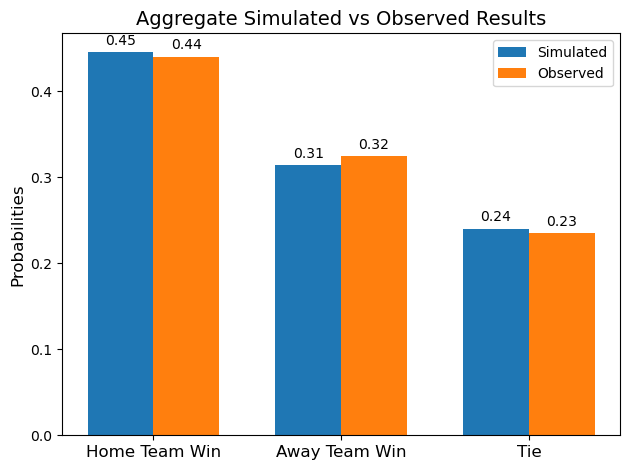

In [13]:
# Calculate mean probabilities and mean observed outcomes for each category
mean_expected = np.mean(list(expected_results.values()), axis=0)
mean_observed = np.mean(list(observed_results.values()), axis=0)

# Plotting the calibration plot
categories = ['Home Team Win', 'Away Team Win', 'Tie']
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mean_expected, width, label='Simulated')
rects2 = ax.bar(x + width/2, mean_observed, width, label='Observed')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Probabilities',fontsize = 12)
ax.set_title('Aggregate Simulated vs Observed Results',fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(categories,fontsize = 12)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

#save figure 
plt.savefig("figures/simulation_vs_true_results.pdf")
plt.show()


### Pearson Goodness of Fit Test
To evaluate if our simulations accurately capture the wi proportion of 

In [14]:
mean_expected

array([0.44537966, 0.31421665, 0.24040369])

In [15]:
mean_observed

array([0.44059977, 0.32449058, 0.23490965])

In [16]:
#number of games 
n = len(expected_results)
#get expected numbers of wins losses and ties 
expected_vector = np.array(mean_expected) * n
#get observed results 
observed_vector = np.array(mean_observed) * n
#pearson goodness of fit statistic
pearson_test_stat = np.sum((observed_vector - expected_vector)**2/(expected_vector))
#pvalue
pvalue = 1-chi2.cdf(pearson_test_stat,2)
#print results
print("Pearson goodness of fit pvalue:" + str(pvalue))

Pearson goodness of fit pvalue:0.5133107737231959


In [17]:
pearson_test_stat

1.333747641001516

### Calibration Between Simulations and True Game Results
We see that our simualtions are also quite calibrated except for at the extremees where large favorites overperform and large underdogs underperform. 

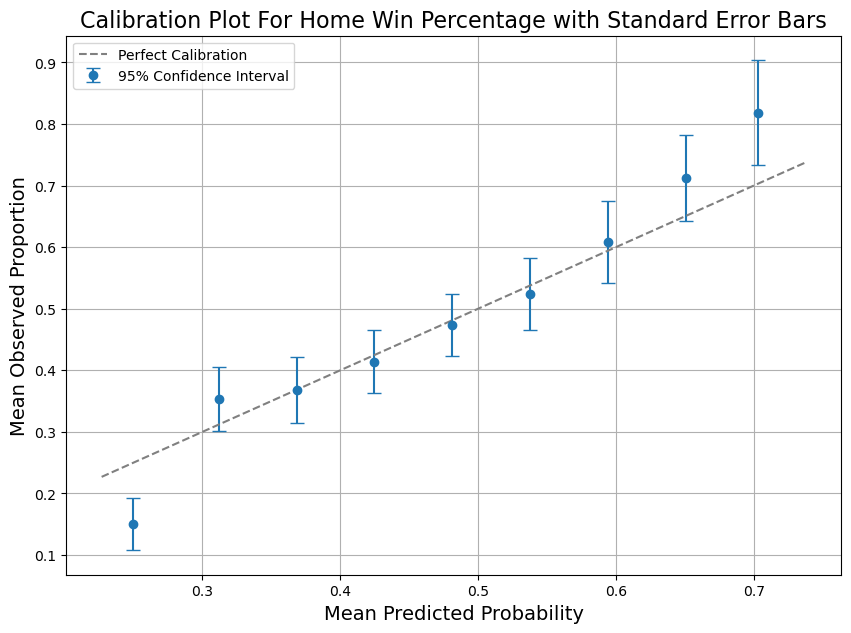

In [18]:
# Extract the second entry from the expected and observed results
expected_first_entry = np.array([v[0] for v in expected_results.values()])
observed_first_entry = np.array([v[0] for v in observed_results.values()])

# Define bin edges between the minimum and maximum of expected_first_entry
bin_edges = np.linspace(expected_first_entry.min(), expected_first_entry.max(), num=10)

# Digitize the expected probabilities to assign them to bins
bins = np.digitize(expected_first_entry, bin_edges) - 1

# Initialize lists to store the mean predicted and observed probabilities for each bin
prob_true = []
prob_pred = []
prob_n = []
error_bars = []

# Calculate the mean predicted and observed probabilities, and standard error for each bin
for i in range(len(bin_edges) - 1):
    bin_mask = bins == i
    n = np.sum(bin_mask)
    if n > 50:  # Ensure the bin has more than 50 observations
        p = np.mean(expected_first_entry[bin_mask])
        prob_true.append(np.mean(observed_first_entry[bin_mask]))
        prob_pred.append(p)
        prob_n.append(n)
        # Calculate the standard error
        se = 1.96 * np.sqrt(p * (1 - p) / n)
        error_bars.append(se)

# Convert lists to numpy arrays for plotting
prob_pred = np.array(prob_pred)
prob_true = np.array(prob_true)
error_bars = np.array(error_bars)

# Plot the calibration plot with error bars
plt.figure(figsize=(10, 7))
plt.errorbar(prob_pred, prob_true, yerr=error_bars, fmt='o', label='95% Confidence Interval', capsize=5)

# Plot perfect calibration line
plt.plot([expected_first_entry.min(), expected_first_entry.max()], 
         [expected_first_entry.min(), expected_first_entry.max()], 
         linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability',fontsize = 14)
plt.ylabel('Mean Observed Proportion',fontsize =14)
plt.title('Calibration Plot For Home Win Percentage with Standard Error Bars',fontsize = 16)
plt.legend()
plt.grid(True)

#save reuslts
plt.savefig("figures/simulation_calibration_plot.pdf")
plt.show()


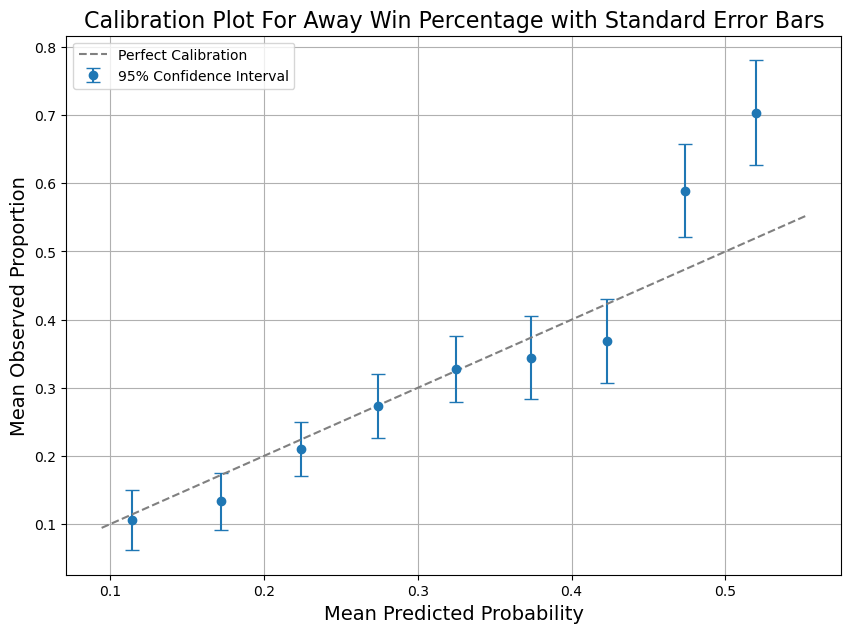

In [19]:
# Extract the second entry from the expected and observed results
expected_first_entry = np.array([v[1] for v in expected_results.values()])
observed_first_entry = np.array([v[1] for v in observed_results.values()])

# Define bin edges between the minimum and maximum of expected_first_entry
bin_edges = np.linspace(expected_first_entry.min(), expected_first_entry.max(), num=10)

# Digitize the expected probabilities to assign them to bins
bins = np.digitize(expected_first_entry, bin_edges) - 1

# Initialize lists to store the mean predicted and observed probabilities for each bin
prob_true = []
prob_pred = []
prob_n = []
error_bars = []

# Calculate the mean predicted and observed probabilities, and standard error for each bin
for i in range(len(bin_edges) - 1):
    bin_mask = bins == i
    n = np.sum(bin_mask)
    if n > 50:  # Ensure the bin has more than 50 observations
        p = np.mean(expected_first_entry[bin_mask])
        prob_true.append(np.mean(observed_first_entry[bin_mask]))
        prob_pred.append(p)
        prob_n.append(n)
        # Calculate the standard error
        se = 1.96 * np.sqrt(p * (1 - p) / n)
        error_bars.append(se)

# Convert lists to numpy arrays for plotting
prob_pred = np.array(prob_pred)
prob_true = np.array(prob_true)
error_bars = np.array(error_bars)

# Plot the calibration plot with error bars
plt.figure(figsize=(10, 7))
plt.errorbar(prob_pred, prob_true, yerr=error_bars, fmt='o', label='95% Confidence Interval', capsize=5)

# Plot perfect calibration line
plt.plot([expected_first_entry.min(), expected_first_entry.max()], 
         [expected_first_entry.min(), expected_first_entry.max()], 
         linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability',fontsize = 14)
plt.ylabel('Mean Observed Proportion',fontsize =14)
plt.title('Calibration Plot For Away Win Percentage with Standard Error Bars',fontsize = 16)
plt.legend()
plt.grid(True)

#save reuslts
plt.savefig("figures/simulation_calibration_plot.pdf")
plt.show()


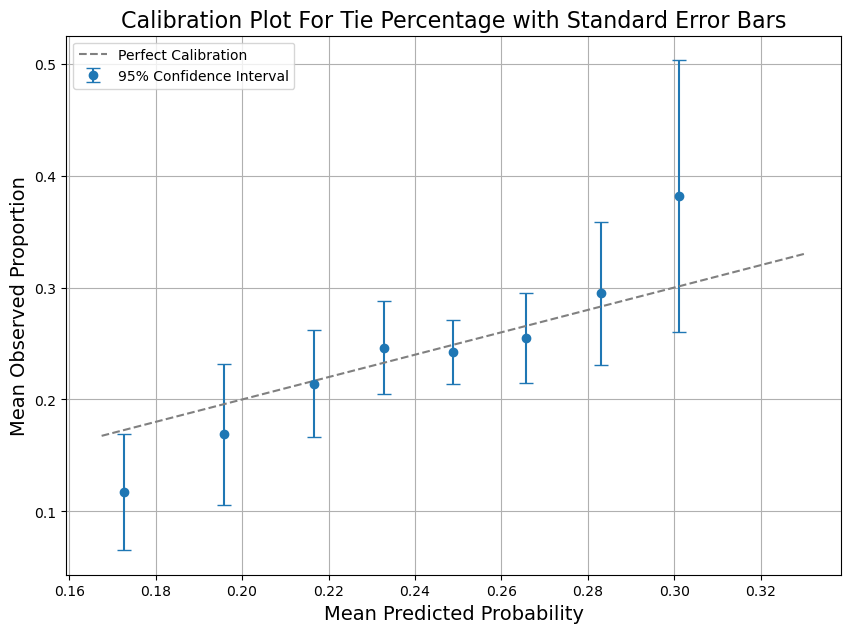

In [20]:
# Extract the second entry from the expected and observed results
expected_first_entry = np.array([v[2] for v in expected_results.values()])
observed_first_entry = np.array([v[2] for v in observed_results.values()])

# Define bin edges between the minimum and maximum of expected_first_entry
bin_edges = np.linspace(expected_first_entry.min(), expected_first_entry.max(), num=10)

# Digitize the expected probabilities to assign them to bins
bins = np.digitize(expected_first_entry, bin_edges) - 1

# Initialize lists to store the mean predicted and observed probabilities for each bin
prob_true = []
prob_pred = []
prob_n = []
error_bars = []

# Calculate the mean predicted and observed probabilities, and standard error for each bin
for i in range(len(bin_edges) - 1):
    bin_mask = bins == i
    n = np.sum(bin_mask)
    if n > 50:  # Ensure the bin has more than 50 observations
        p = np.mean(expected_first_entry[bin_mask])
        prob_true.append(np.mean(observed_first_entry[bin_mask]))
        prob_pred.append(p)
        prob_n.append(n)
        # Calculate the standard error
        se = 1.96 * np.sqrt(p * (1 - p) / n)
        error_bars.append(se)

# Convert lists to numpy arrays for plotting
prob_pred = np.array(prob_pred)
prob_true = np.array(prob_true)
error_bars = np.array(error_bars)

# Plot the calibration plot with error bars
plt.figure(figsize=(10, 7))
plt.errorbar(prob_pred, prob_true, yerr=error_bars, fmt='o', label='95% Confidence Interval', capsize=5)

# Plot perfect calibration line
plt.plot([expected_first_entry.min(), expected_first_entry.max()], 
         [expected_first_entry.min(), expected_first_entry.max()], 
         linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability',fontsize = 14)
plt.ylabel('Mean Observed Proportion',fontsize =14)
plt.title('Calibration Plot For Tie Percentage with Standard Error Bars',fontsize = 16)
plt.legend()
plt.grid(True)

#save reuslts
plt.savefig("figures/simulation_calibration_plot.pdf")
plt.show()


### Saving Results
We save the game state correlation dictionary for future notbeooks that may require simulations.

In [21]:
import pickle

# Your dictionary
# Save the dictionary to a file
with open('data/game_state_correlations.pkl', 'wb') as f:
    pickle.dump(correlation_by_game_state, f)

